# OpenJij Parameter Benchmarking for AP Selection

This notebook benchmarks OpenJij parameters for QUBO-based Access Point selection using **entropy importance** metric.

## Benchmarking Strategy:

1. **Phase 1: QUBO Parameter Optimization**
   - Benchmark `k` (number of APs), `alpha` (importance weight), `penalty` values
   - Find best combination for positioning accuracy

2. **Phase 2: OpenJij Annealing Parameters**
   - Benchmark `num_sweeps`, `num_reads`, `beta`, `gamma`
   - Optimize for lowest Time-to-Solution (TTS)
   - Track floor accuracy for each configuration

3. **Phase 3: OpenJij vs D-Wave SA Comparison**
   - Compare best OpenJij configuration vs D-Wave SA
   - Evaluate TTS, positioning accuracy, and floor accuracy

Reference: [OpenJij Evaluation Tutorial](https://tutorial.openjij.org/en/tutorial/005-Evaluation.html)

## Setup: Imports and Configuration

In [12]:
# Add project root to Python path
import sys
from pathlib import Path


project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

print(f"✓ Project root: {project_root}")

✓ Project root: c:\Users\Mohamed Khalil\Desktop\Quantum-Optimization-In-AP-Selection


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import openjij as oj
import time
import warnings
from datetime import datetime
from itertools import product

# Import custom modules
from scripts.data.data_loaders import (
    load_preprocessed_data,
    load_all_precomputed_data
)

from scripts.optimization.QUBO import (
    formulate_qubo,
    solve_qubo_with_openjij,
    solve_qubo_with_SA
)

from scripts.ml.ML_post_processing import train_regressor
from scripts.evaluation.Analysis import calculate_comprehensive_metrics

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## Load Data and System Parameters

In [14]:
# Load preprocessed data for Building 1
building_id = 1

rssi_train, coords_train, rssi_val, coords_val, ap_columns = load_preprocessed_data(
    building_id=building_id,
    use_pickle=True
)

scaler_coords = MinMaxScaler()
scaler_coords.fit(coords_train)

print(f"✓ Loaded Building {building_id} data:")
print(f"  Training samples: {rssi_train.shape[0]}")
print(f"  Validation samples: {rssi_val.shape[0]}")
print(f"  Number of APs: {len(ap_columns)}")

[OK] Loaded preprocessed data from pickle: C:\Users\Mohamed Khalil\Desktop\Quantum-Optimization-In-AP-Selection\data\output_data\preprocessed_data\preprocessed_building_1.pkl
  Training samples: 5196
  Validation samples: 307
  Number of APs: 520
✓ Loaded Building 1 data:
  Training samples: 5196
  Validation samples: 307
  Number of APs: 520


In [15]:
# Load importance scores and redundancy matrix
importance_dicts, redundancy_matrix = load_all_precomputed_data()

# Use ONLY entropy importance for this benchmark
importance_entropy = importance_dicts['entropy']

print(f"✓ Loaded entropy importance scores: {len(importance_entropy)} APs")
print(f"✓ Loaded redundancy matrix: {redundancy_matrix.shape}")

Loading pre-computed importance scores and redundancy matrix

Loading importance scores...
[OK] Loaded 520 APs for entropy importance
[OK] Loaded 520 APs for average importance
[OK] Loaded 520 APs for median importance
[OK] Loaded 520 APs for max importance
[OK] Loaded 520 APs for variance importance
[OK] Loaded 520 APs for mutual_info importance

Loading redundancy matrix...
[OK] Loaded redundancy matrix with shape: (520, 520)

[OK] All data loaded successfully!
✓ Loaded entropy importance scores: 520 APs
✓ Loaded redundancy matrix: (520, 520)


In [16]:
# Load system parameters
system_params_path = Path('../../data') / 'system_input' / 'system_parameters.csv'
system_params_df = pd.read_csv(system_params_path)
system_params_dict = dict(zip(system_params_df['Parameter'], system_params_df['Value']))

LON_MIN = system_params_dict['LON_MIN']
LON_MAX = system_params_dict['LON_MAX']
LAT_MIN = system_params_dict['LAT_MIN']
LAT_MAX = system_params_dict['LAT_MAX']
FLOOR_HEIGHT = system_params_dict['FLOOR_HEIGHT']

print("✓ System parameters loaded")

✓ System parameters loaded


---
# Phase 1: QUBO Parameter Benchmarking (OPTIONAL)

**Option 1**: Load existing Phase 1 results from file (FAST - use this if you already ran Phase 1)
**Option 2**: Run Phase 1 benchmark from scratch (SLOW - only if you need to re-run)

Benchmark different combinations of:
- `k`: Number of APs to select
- `alpha`: Importance vs redundancy weight (0-1)
- `penalty`: Constraint violation penalty

In [7]:
# OPTION 1: Load Phase 1 results from existing file (RECOMMENDED)
# If you already ran Phase 1, load the results directly

try:
    phase1_file = Path('../../data/results/phase1_openjij_parameters.xlsx')
    
    if phase1_file.exists():
        print("="*80)
        print("LOADING PHASE 1 RESULTS FROM FILE")
        print("="*80)
        
        phase1_df = pd.read_excel(phase1_file)
        
        print(f"\n✓ Loaded Phase 1 results from: {phase1_file}")
        print(f"  Total configurations: {len(phase1_df)}")
        print(f"  Columns: {phase1_df.columns.tolist()}")
        
        # Sort by mean 3D error
        phase1_df_sorted = phase1_df.sort_values('mean_3d_error_m')
        
        print("\n✓ Top 5 Best Configurations (by Mean 3D Error):")
        print(phase1_df_sorted[['k', 'alpha', 'penalty', 'mean_3d_error_m', 
                                 'floor_accuracy_0', 'floor_accuracy_1']].head().to_string(index=False))
        
        # Extract best configuration
        best_config = phase1_df_sorted.iloc[0]
        best_k = int(best_config['k'])
        best_alpha = best_config['alpha']
        best_penalty = best_config['penalty']
        
        print("\n" + "="*80)
        print("BEST QUBO PARAMETERS (from loaded file)")
        print("="*80)
        print(f"k = {best_k}")
        print(f"alpha = {best_alpha}")
        print(f"penalty = {best_penalty}")
        print(f"Mean 3D Error: {best_config['mean_3d_error_m']:.2f}m")
        print(f"Floor Accuracy (exact): {best_config['floor_accuracy_0']:.2%}")
        print(f"Floor Accuracy (±1): {best_config['floor_accuracy_1']:.2%}")
        print("="*80)
        
        print("\n✓ Phase 1 loaded successfully! Proceeding to Phase 2...")
        
        PHASE1_LOADED = True
    else:
        print(f"Phase 1 file not found at: {phase1_file}")
        print("Please run OPTION 2 below to generate Phase 1 results.")
        PHASE1_LOADED = False
        
except Exception as e:
    print(f"Error loading Phase 1 results: {e}")
    print("Please run OPTION 2 below to generate Phase 1 results.")
    PHASE1_LOADED = False

LOADING PHASE 1 RESULTS FROM FILE

✓ Loaded Phase 1 results from: ..\..\data\results\phase1_openjij_parameters.xlsx
  Total configurations: 96
  Columns: ['k', 'alpha', 'penalty', 'num_aps_selected', 'qubo_time_s', 'mean_3d_error_m', 'median_3d_error_m', 'floor_accuracy_0', 'floor_accuracy_1', 'floor_accuracy_2']

✓ Top 5 Best Configurations (by Mean 3D Error):
 k  alpha  penalty  mean_3d_error_m  floor_accuracy_0  floor_accuracy_1
20   0.90      1.5        13.161723          0.654723          0.980456
50   0.80      2.5        13.660445          0.742671          0.983713
40   0.80      1.5        13.750308          0.693811          0.967427
40   0.90      2.5        13.789086          0.677524          0.980456
40   0.95      2.5        14.021964          0.811075          1.000000

BEST QUBO PARAMETERS (from loaded file)
k = 20
alpha = 0.9
penalty = 1.5
Mean 3D Error: 13.16m
Floor Accuracy (exact): 65.47%
Floor Accuracy (±1): 98.05%

✓ Phase 1 loaded successfully! Proceeding to Pha

In [8]:
# OPTION 2: Run Phase 1 benchmark from scratch (ONLY run if OPTION 1 failed)
# This will take a long time! Skip this cell if Phase 1 was loaded successfully above.

if not PHASE1_LOADED:
    print("="*80)
    print("RUNNING PHASE 1: BENCHMARKING QUBO PARAMETERS (k, alpha, penalty)")
    print("="*80)
    
    # Define parameter grid
    k_values = [15, 20, 25, 30]
    alpha_values = [0.7, 0.8, 0.9, 0.95]
    penalty_values = [1.5, 2.0, 2.5]
    
    print(f"\nParameter Grid:")
    print(f"  k values: {k_values}")
    print(f"  alpha values: {alpha_values}")
    print(f"  penalty values: {penalty_values}")
    print(f"  Total combinations: {len(k_values) * len(alpha_values) * len(penalty_values)}")
    
    phase1_results = []
    total_combinations = len(k_values) * len(alpha_values) * len(penalty_values)
    current_combo = 0

    for k, alpha, penalty in product(k_values, alpha_values, penalty_values):
        current_combo += 1
        print(f"\n[{current_combo}/{total_combinations}] Testing k={k}, alpha={alpha}, penalty={penalty}")
        
        try:
            # 1. Formulate QUBO
            Q, relevant_aps, offset = formulate_qubo(
                importance_entropy, redundancy_matrix, k, alpha, penalty
            )
            
            if len(relevant_aps) == 0:
                print("  ✗ Skipped: No relevant APs")
                continue
            
            # 2. Solve with OpenJij (default parameters)
            selected_indices, qubo_time = solve_qubo_with_openjij(Q)
            
            if len(selected_indices) == 0:
                print("  ✗ Skipped: No APs selected")
                continue
            
            selected_aps = [relevant_aps[i] for i in selected_indices]
            
            # 3. Train ML model
            models, predictions = train_regressor(
                rssi_train, coords_train, rssi_val, coords_val, selected_aps
            )
            preds = predictions['rf_val']
            
            # 4. Evaluate
            _, _, metrics = calculate_comprehensive_metrics(
                coords_val, preds, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX, FLOOR_HEIGHT
            )
            
            # 5. Store results
            phase1_results.append({
                'k': k,
                'alpha': alpha,
                'penalty': penalty,
                'num_aps_selected': len(selected_aps),
                'qubo_time_s': qubo_time,
                'mean_3d_error_m': metrics['real_mean_m'],
                'median_3d_error_m': metrics['real_median_m'],
                'floor_accuracy_0': metrics['floor_accuracy_0'],
                'floor_accuracy_1': metrics['floor_accuracy_1'],
                'floor_accuracy_2': metrics['floor_accuracy_2']
            })
            
            print(f"  ✓ Selected {len(selected_aps)} APs")
            print(f"    Mean 3D Error: {metrics['real_mean_m']:.2f}m")
            print(f"    Floor Acc (exact): {metrics['floor_accuracy_0']:.2%}")
            
        except Exception as e:
            print(f"  ✗ Error: {e}")
            continue

    # Convert to DataFrame
    phase1_df = pd.DataFrame(phase1_results)
    
    # Save to file
    output_file = Path('../../data/results/phase1_openjij_parameters.xlsx')
    phase1_df.to_excel(output_file, index=False)
    print(f"\n✓ Phase 1 results saved to: {output_file}")

    # Sort and extract best configuration
    phase1_df_sorted = phase1_df.sort_values('mean_3d_error_m')
    best_config = phase1_df_sorted.iloc[0]
    best_k = int(best_config['k'])
    best_alpha = best_config['alpha']
    best_penalty = best_config['penalty']
    
    print("\n" + "="*80)
    print(f"✓ Phase 1 completed: {len(phase1_results)} successful combinations")
    print("="*80)
else:
    print("Skipping Phase 1 - already loaded from file")

Skipping Phase 1 - already loaded from file


In [9]:
phase1_df.to_excel("../../data/results/phase2_openjij_parameters.xlsx", index=False)

In [17]:
# Analyze Phase 1 results
print("\n" + "="*80)
print("PHASE 1 RESULTS SUMMARY")
print("="*80)

# Sort by mean 3D error
phase1_df_sorted = phase1_df.sort_values('mean_3d_error_m')

print("\nTop 5 Best Configurations (by Mean 3D Error):")
print(phase1_df_sorted[['k', 'alpha', 'penalty', 'mean_3d_error_m', 
                         'floor_accuracy_0', 'floor_accuracy_1']].head().to_string(index=False))

# Best configuration
best_config = phase1_df_sorted.iloc[0]
best_k = int(best_config['k'])
best_alpha = best_config['alpha']
best_penalty = best_config['penalty']

print("\n" + "="*80)
print("BEST QUBO PARAMETERS")
print("="*80)
print(f"k = {best_k}")
print(f"alpha = {best_alpha}")
print(f"penalty = {best_penalty}")
print(f"Mean 3D Error: {best_config['mean_3d_error_m']:.2f}m")
print(f"Floor Accuracy (exact): {best_config['floor_accuracy_0']:.2%}")
print(f"Floor Accuracy (±1): {best_config['floor_accuracy_1']:.2%}")
print("="*80)


PHASE 1 RESULTS SUMMARY

Top 5 Best Configurations (by Mean 3D Error):
 k  alpha  penalty  mean_3d_error_m  floor_accuracy_0  floor_accuracy_1
20   0.90      1.5        13.161723          0.654723          0.980456
50   0.80      2.5        13.660445          0.742671          0.983713
40   0.80      1.5        13.750308          0.693811          0.967427
40   0.90      2.5        13.789086          0.677524          0.980456
40   0.95      2.5        14.021964          0.811075          1.000000

BEST QUBO PARAMETERS
k = 20
alpha = 0.9
penalty = 1.5
Mean 3D Error: 13.16m
Floor Accuracy (exact): 65.47%
Floor Accuracy (±1): 98.05%


NameError: name 'alpha_values' is not defined

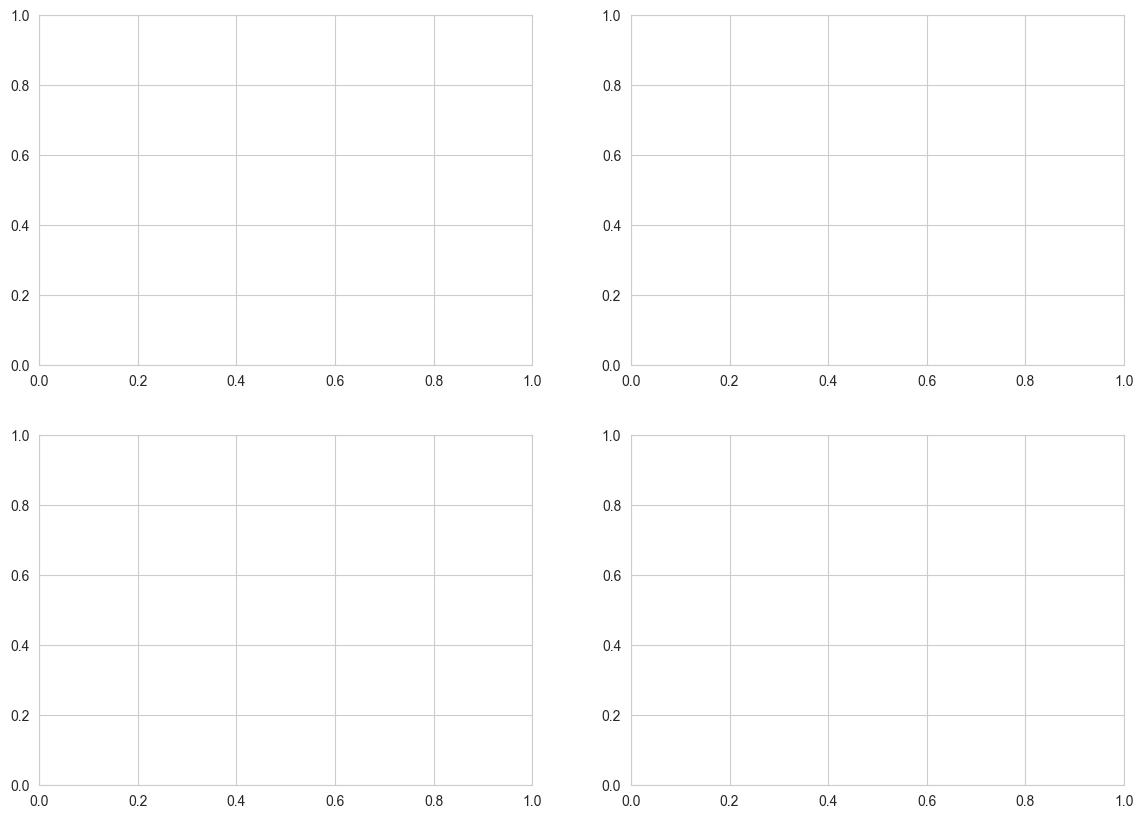

In [11]:
# Visualize Phase 1 results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Mean 3D Error vs k for different alphas
for alpha in alpha_values:
    subset = phase1_df[phase1_df['alpha'] == alpha]
    axes[0, 0].plot(subset['k'], subset['mean_3d_error_m'], marker='o', label=f'α={alpha}')
axes[0, 0].set_xlabel('k (Number of APs)')
axes[0, 0].set_ylabel('Mean 3D Error (m)')
axes[0, 0].set_title('Mean 3D Error vs k')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Floor Accuracy vs alpha
for k_val in k_values:
    subset = phase1_df[phase1_df['k'] == k_val]
    axes[0, 1].plot(subset['alpha'], subset['floor_accuracy_0'], marker='s', label=f'k={k_val}')
axes[0, 1].set_xlabel('Alpha')
axes[0, 1].set_ylabel('Floor Accuracy (exact)')
axes[0, 1].set_title('Floor Accuracy vs Alpha')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Heatmap of Mean 3D Error (k vs alpha)
pivot_table = phase1_df.pivot_table(values='mean_3d_error_m', index='k', columns='alpha', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='RdYlGn_r', ax=axes[1, 0])
axes[1, 0].set_title('Mean 3D Error Heatmap (k vs alpha)')

# Plot 4: Penalty effect
for penalty_val in penalty_values:
    subset = phase1_df[phase1_df['penalty'] == penalty_val]
    axes[1, 1].scatter(subset['mean_3d_error_m'], subset['floor_accuracy_0'], 
                       label=f'penalty={penalty_val}', s=100, alpha=0.6)
axes[1, 1].set_xlabel('Mean 3D Error (m)')
axes[1, 1].set_ylabel('Floor Accuracy (exact)')
axes[1, 1].set_title('Positioning Accuracy vs Floor Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('../../data/results/phase1_qubo_parameters.png', dpi=150)
plt.show()

print("✓ Phase 1 visualizations saved")

---
# Phase 2: OpenJij Annealing Parameter Optimization (STANDALONE)

**Phase 2 loads Phase 1 results independently - you can run Phase 2 without running Phase 1 in this session**

This phase optimizes OpenJij annealing parameters:
- `num_sweeps`: Number of Monte Carlo sweeps
- `num_reads`: Number of independent runs
- `beta`: Inverse temperature (higher = colder = more exploitation)
- `gamma`: Transverse field strength (higher = more quantum tunneling)

**Goal**: Minimize Time-to-Solution (TTS) while maintaining good floor accuracy

In [6]:
# ============================================================================
# PHASE 2 STANDALONE SETUP: Load Phase 1 Results from File
# ============================================================================
# Phase 2 can run completely independently - it loads best parameters from
# Phase 1 Excel file, so you don't need to run Phase 1 in this session

print("\n" + "="*80)
print("PHASE 2: LOADING BEST QUBO PARAMETERS FROM PHASE 1 FILE")
print("="*80)

# Load Phase 1 results from file
phase1_file = Path('../../data/results/phase1_openjij_parameters.xlsx')

if not phase1_file.exists():
    raise FileNotFoundError(
        f"Phase 1 results file not found: {phase1_file}\n"
        "Please run Phase 1 first to generate the file."
    )

# Load and extract best parameters
phase1_df_p2 = pd.read_excel(phase1_file)
print(f"\n✓ Loaded Phase 1 results from: {phase1_file}")
print(f"  Total configurations: {len(phase1_df_p2)}")

# Sort by mean 3D error to find best configuration
phase1_df_p2_sorted = phase1_df_p2.sort_values('mean_3d_error_m')

print("\n✓ Top 5 Best Configurations (by Mean 3D Error):")
print(phase1_df_p2_sorted[['k', 'alpha', 'penalty', 'mean_3d_error_m', 
                            'floor_accuracy_0', 'floor_accuracy_1']].head().to_string(index=False))

# Extract best configuration parameters
best_config_p2 = phase1_df_p2_sorted.iloc[0]
best_k = int(best_config_p2['k'])
best_alpha = best_config_p2['alpha']
best_penalty = best_config_p2['penalty']

print("\n" + "="*80)
print("BEST QUBO PARAMETERS (loaded from Phase 1 file)")
print("="*80)
print(f"k = {best_k}")
print(f"alpha = {best_alpha}")
print(f"penalty = {best_penalty}")
print(f"Mean 3D Error: {best_config_p2['mean_3d_error_m']:.2f}m")
print(f"Floor Accuracy (exact): {best_config_p2['floor_accuracy_0']:.2%}")
print(f"Floor Accuracy (±1): {best_config_p2['floor_accuracy_1']:.2%}")
print("="*80)

print("\n✓ Phase 2 is ready to run with loaded parameters!")



PHASE 2: LOADING BEST QUBO PARAMETERS FROM PHASE 1 FILE

✓ Loaded Phase 1 results from: ..\..\data\results\phase1_openjij_parameters.xlsx
  Total configurations: 96

✓ Top 5 Best Configurations (by Mean 3D Error):
 k  alpha  penalty  mean_3d_error_m  floor_accuracy_0  floor_accuracy_1
20   0.90      1.5        13.161723          0.654723          0.980456
50   0.80      2.5        13.660445          0.742671          0.983713
40   0.80      1.5        13.750308          0.693811          0.967427
40   0.90      2.5        13.789086          0.677524          0.980456
40   0.95      2.5        14.021964          0.811075          1.000000

BEST QUBO PARAMETERS (loaded from Phase 1 file)
k = 20
alpha = 0.9
penalty = 1.5
Mean 3D Error: 13.16m
Floor Accuracy (exact): 65.47%
Floor Accuracy (±1): 98.05%

✓ Phase 2 is ready to run with loaded parameters!


In [7]:
# Phase 2 parameter grid
num_sweeps_values = [100, 500, 1000, 2000]
num_reads_values = [10, 50, 100]
beta_values = [0.5, 1.0, 5.0, 10.0]  # Inverse temperature (single value)
gamma_values = [0.1, 1.0, 2.0]  # Transverse field strength

print("\n" + "="*80)
print("PHASE 2: OPENJIJ ANNEALING PARAMETER GRID")
print("="*80)
print(f"  num_sweeps: {num_sweeps_values}")
print(f"  num_reads: {num_reads_values}")
print(f"  beta (inverse temperature): {beta_values}")
print(f"  gamma (transverse field): {gamma_values}")
print(f"  Total combinations: {len(num_sweeps_values) * len(num_reads_values) * len(beta_values) * len(gamma_values)}")
print("\nUsing best QUBO parameters from Phase 1:")
print(f"  k = {best_k}")
print(f"  alpha = {best_alpha}")
print(f"  penalty = {best_penalty}")
print("="*80)


PHASE 2: OPENJIJ ANNEALING PARAMETER GRID
  num_sweeps: [100, 500, 1000, 2000]
  num_reads: [10, 50, 100]
  beta (inverse temperature): [0.5, 1.0, 5.0, 10.0]
  gamma (transverse field): [0.1, 1.0, 2.0]
  Total combinations: 144

Using best QUBO parameters from Phase 1:
  k = 20
  alpha = 0.9
  penalty = 1.5


In [8]:
# Helper function for custom OpenJij solving with parameters
def solve_qubo_with_openjij_custom(Q, num_sweeps=1000, num_reads=100, beta=5.0, gamma=1.0):
    """
    Solve QUBO with custom OpenJij parameters
    
    Args:
        Q: QUBO matrix
        num_sweeps: Number of Monte Carlo sweeps (default: 1000)
        num_reads: Number of independent runs (default: 100)
        beta: Inverse temperature - higher = colder = more exploitation (default: 5.0)
        gamma: Transverse field strength - higher = more quantum tunneling (default: 1.0)
    
    Returns:
        selected_indices: List of selected AP indices
        duration: Time taken in seconds
        success_rate: Fraction of reads that found good solutions
    """
    start_time = time.time()
    
    # Create SQA sampler
    sampler = oj.SQASampler()
    
    # Sample with parameters
    response = sampler.sample_qubo(
        Q, 
        num_sweeps=num_sweeps,
        num_reads=num_reads,
        beta=beta,
        gamma=gamma
    )
    
    duration = time.time() - start_time
    
    # Get best solution
    best_sample = response.first.sample
    selected_indices = [i for i, val in best_sample.items() if val == 1]
    
    # Calculate success rate (solutions with exact k APs selected)
    target_k = sum(best_sample.values())
    success_count = 0
    
    for record in response.record:
        # record.sample is a numpy array
        num_selected = np.sum(record.sample)
        if num_selected == target_k:
            success_count += 1
    
    success_rate = success_count / num_reads if num_reads > 0 else 0.0
    
    return selected_indices, duration, success_rate

print("✓ Custom OpenJij solver function defined")

✓ Custom OpenJij solver function defined


In [9]:
# Formulate QUBO once with best parameters
print("Formulating QUBO with best parameters...")
Q_best, relevant_aps_best, offset_best = formulate_qubo(
    importance_entropy, redundancy_matrix, best_k, best_alpha, best_penalty
)
print(f"✓ QUBO formulated with {len(relevant_aps_best)} relevant APs")

Formulating QUBO with best parameters...
Formulating enhanced QUBO for k=20 APs selection...
Done
✓ QUBO formulated with 207 relevant APs


In [10]:
# Phase 2: Benchmark OpenJij parameters
phase2_results = []

print("\n" + "="*80)
print("PHASE 2: BENCHMARKING OPENJIJ ANNEALING PARAMETERS")
print("="*80)

total_combinations = (len(num_sweeps_values) * len(num_reads_values) * 
                     len(beta_values) * len(gamma_values))
current_combo = 0

for num_sweeps, num_reads, beta, gamma in product(
    num_sweeps_values, num_reads_values, beta_values, gamma_values
):
    current_combo += 1
    print(f"\n[{current_combo}/{total_combinations}] Testing: sweeps={num_sweeps}, reads={num_reads}, β={beta}, γ={gamma}")
    
    try:
        # Solve with custom parameters
        selected_indices, qubo_time, success_rate = solve_qubo_with_openjij_custom(
            Q_best, num_sweeps, num_reads, beta, gamma
        )
        
        if len(selected_indices) == 0:
            print("  ✗ Skipped: No APs selected")
            continue
        
        selected_aps = [relevant_aps_best[i] for i in selected_indices]
        
        # Train ML model
        models, predictions = train_regressor(
            rssi_train, coords_train, rssi_val, coords_val, selected_aps
        )
        preds = predictions['rf_val']
        
        # Evaluate
        _, _, metrics = calculate_comprehensive_metrics(
            coords_val, preds, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX, FLOOR_HEIGHT
        )
        
        # Calculate Time-to-Solution (TTS)
        # TTS = time * log(1 - P_target) / log(1 - P_success)
        # Assuming target probability P_target = 0.99
        P_target = 0.99
        if success_rate > 0 and success_rate < 1:
            tts = qubo_time * np.log(1 - P_target) / np.log(1 - success_rate)
        elif success_rate >= 1:
            tts = qubo_time  # Already 100% success
        else:
            tts = float('inf')  # Never succeeds
        
        # Store results
        phase2_results.append({
            'num_sweeps': num_sweeps,
            'num_reads': num_reads,
            'beta': beta,
            'gamma': gamma,
            'num_aps_selected': len(selected_aps),
            'qubo_time_s': qubo_time,
            'success_rate': success_rate,
            'tts_s': tts,
            'mean_3d_error_m': metrics['real_mean_m'],
            'median_3d_error_m': metrics['real_median_m'],
            'floor_accuracy_0': metrics['floor_accuracy_0'],
            'floor_accuracy_1': metrics['floor_accuracy_1'],
            'floor_accuracy_2': metrics['floor_accuracy_2']
        })
        
        print(f"  ✓ Time: {qubo_time:.2f}s, TTS: {tts:.2f}s, Success Rate: {success_rate:.2%}")
        print(f"    Mean 3D Error: {metrics['real_mean_m']:.2f}m, Floor Acc: {metrics['floor_accuracy_0']:.2%}")
        
    except Exception as e:
        print(f"  ✗ Error: {e}")
        continue

# Convert to DataFrame
phase2_df = pd.DataFrame(phase2_results)

print("\n" + "="*80)
print(f"✓ Phase 2 completed: {len(phase2_results)} successful combinations")
print("="*80)


PHASE 2: BENCHMARKING OPENJIJ ANNEALING PARAMETERS

[1/144] Testing: sweeps=100, reads=10, β=0.5, γ=0.1
Training random forest regressor...
✓ Enhanced Random Forest trained
   Average OOB Score: 0.6478
  ✓ Time: 0.17s, TTS: 7.43s, Success Rate: 10.00%
    Mean 3D Error: 26.80m, Floor Acc: 62.87%

[2/144] Testing: sweeps=100, reads=10, β=0.5, γ=1.0
Training random forest regressor...
✓ Enhanced Random Forest trained
   Average OOB Score: 0.6557
  ✓ Time: 0.15s, TTS: 0.44s, Success Rate: 80.00%
    Mean 3D Error: 29.08m, Floor Acc: 59.61%

[3/144] Testing: sweeps=100, reads=10, β=0.5, γ=2.0
Training random forest regressor...
✓ Enhanced Random Forest trained
   Average OOB Score: 0.8153
  ✓ Time: 0.14s, TTS: 1.28s, Success Rate: 40.00%
    Mean 3D Error: 25.79m, Floor Acc: 68.40%

[4/144] Testing: sweeps=100, reads=10, β=1.0, γ=0.1
Training random forest regressor...
✓ Enhanced Random Forest trained
   Average OOB Score: 0.8184
  ✓ Time: 0.14s, TTS: 1.86s, Success Rate: 30.00%
    Mean 

In [13]:
phase2_df.to_excel("../../data/results/phase2_openjij_parameters.xlsx", index=False)

In [11]:
# Analyze Phase 2 results
print("\n" + "="*80)
print("PHASE 2 RESULTS SUMMARY")
print("="*80)

# Sort by TTS (lower is better)
phase2_df_sorted = phase2_df[phase2_df['tts_s'] != float('inf')].sort_values('tts_s')

print("\nTop 5 Best Configurations (by Time-to-Solution):")
print(phase2_df_sorted[['num_sweeps', 'num_reads', 'beta', 'gamma', 
                         'tts_s', 'floor_accuracy_0', 'mean_3d_error_m']].head().to_string(index=False))

# Best configuration
best_oj_config = phase2_df_sorted.iloc[0]
best_num_sweeps = int(best_oj_config['num_sweeps'])
best_num_reads = int(best_oj_config['num_reads'])
best_beta = best_oj_config['beta']
best_gamma = best_oj_config['gamma']

print("\n" + "="*80)
print("BEST OPENJIJ PARAMETERS")
print("="*80)
print(f"num_sweeps = {best_num_sweeps}")
print(f"num_reads = {best_num_reads}")
print(f"beta = {best_beta}")
print(f"gamma = {best_gamma}")
print(f"Time-to-Solution: {best_oj_config['tts_s']:.2f}s")
print(f"Success Rate: {best_oj_config['success_rate']:.2%}")
print(f"Mean 3D Error: {best_oj_config['mean_3d_error_m']:.2f}m")
print(f"Floor Accuracy (exact): {best_oj_config['floor_accuracy_0']:.2%}")
print(f"Floor Accuracy (±1): {best_oj_config['floor_accuracy_1']:.2%}")
print("="*80)


PHASE 2 RESULTS SUMMARY

Top 5 Best Configurations (by Time-to-Solution):
 num_sweeps  num_reads  beta  gamma    tts_s  floor_accuracy_0  mean_3d_error_m
        100         10  10.0    1.0 0.147134          0.726384        18.302442
        100         10   5.0    2.0 0.151112          0.635179        18.761087
        100         10  10.0    0.1 0.156365          0.612378        22.135077
        100         10   5.0    0.1 0.157490          0.654723        22.113697
        500         10   5.0    0.1 0.188185          0.625407        26.036253

BEST OPENJIJ PARAMETERS
num_sweeps = 100
num_reads = 10
beta = 10.0
gamma = 1.0
Time-to-Solution: 0.15s
Success Rate: 100.00%
Mean 3D Error: 18.30m
Floor Accuracy (exact): 72.64%
Floor Accuracy (±1): 95.11%


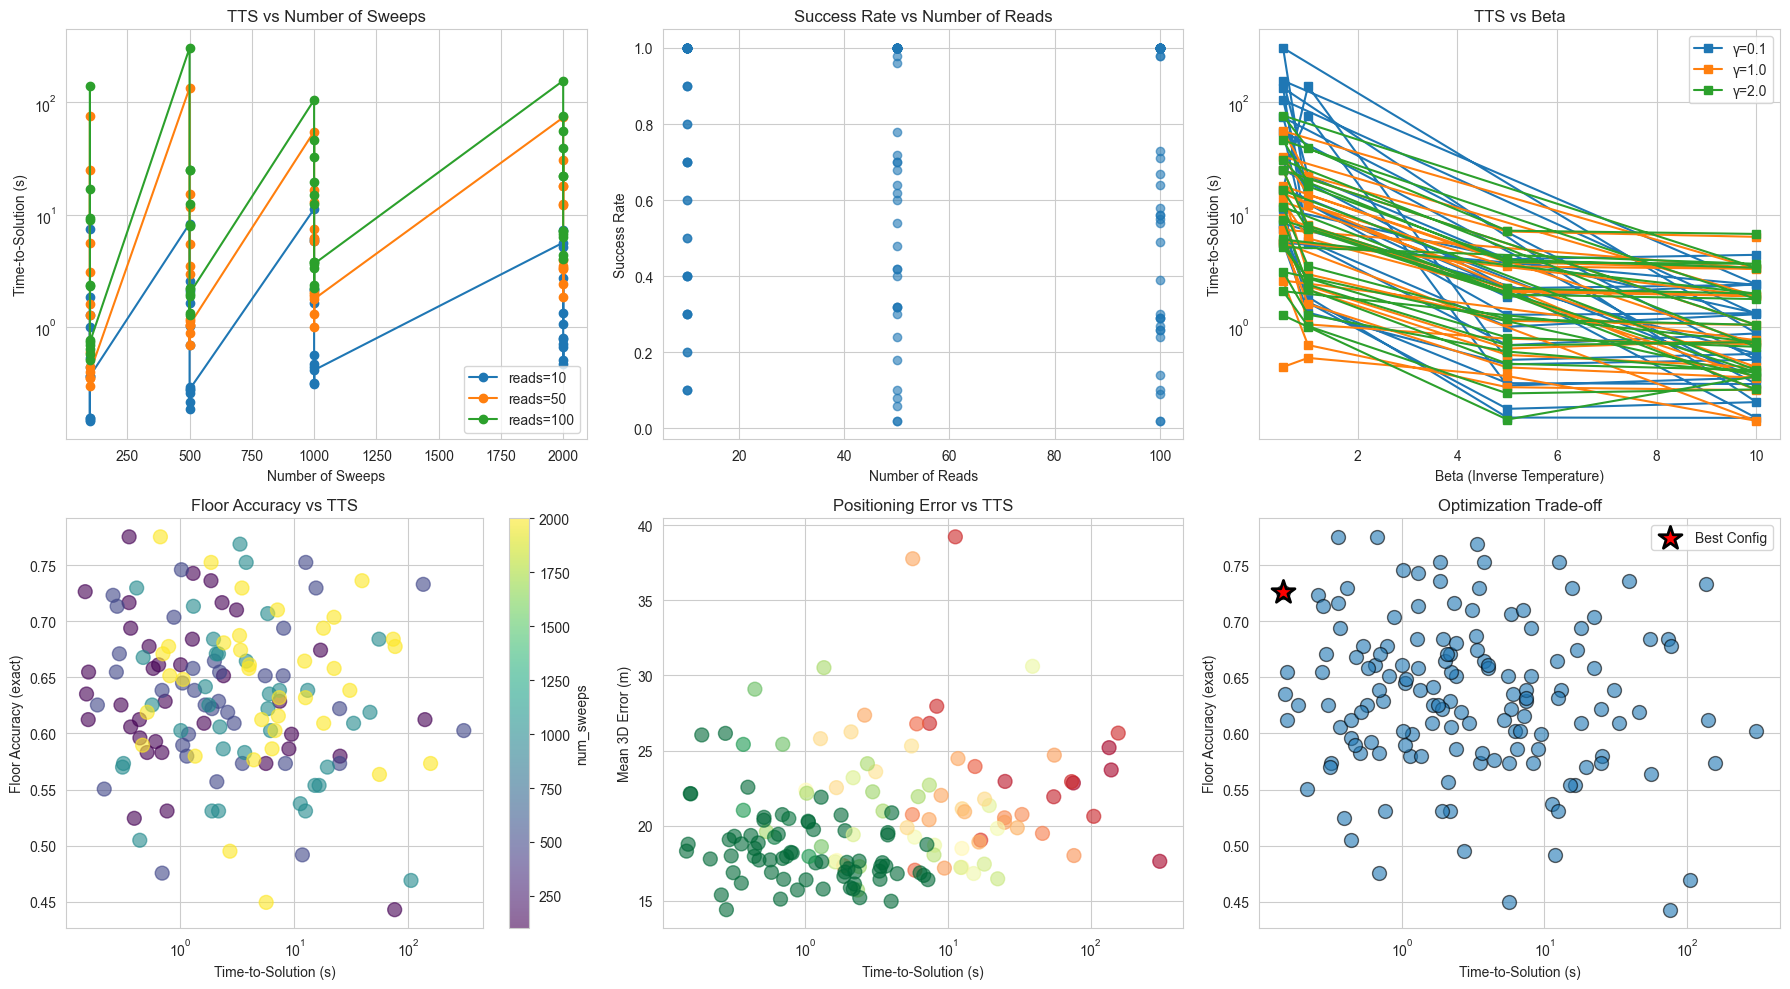

✓ Phase 2 visualizations saved


In [12]:
# Visualize Phase 2 results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Filter out infinite TTS
phase2_finite = phase2_df[phase2_df['tts_s'] != float('inf')]

# Plot 1: TTS vs num_sweeps
for num_reads_val in num_reads_values:
    subset = phase2_finite[phase2_finite['num_reads'] == num_reads_val]
    axes[0, 0].plot(subset['num_sweeps'], subset['tts_s'], marker='o', label=f'reads={num_reads_val}')
axes[0, 0].set_xlabel('Number of Sweeps')
axes[0, 0].set_ylabel('Time-to-Solution (s)')
axes[0, 0].set_title('TTS vs Number of Sweeps')
axes[0, 0].legend()
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True)

# Plot 2: Success Rate vs num_reads
axes[0, 1].scatter(phase2_finite['num_reads'], phase2_finite['success_rate'], alpha=0.6)
axes[0, 1].set_xlabel('Number of Reads')
axes[0, 1].set_ylabel('Success Rate')
axes[0, 1].set_title('Success Rate vs Number of Reads')
axes[0, 1].grid(True)

# Plot 3: TTS vs beta
for gamma_val in gamma_values:
    subset = phase2_finite[phase2_finite['gamma'] == gamma_val]
    axes[0, 2].plot(subset['beta'], subset['tts_s'], marker='s', label=f'γ={gamma_val}')
axes[0, 2].set_xlabel('Beta (Inverse Temperature)')
axes[0, 2].set_ylabel('Time-to-Solution (s)')
axes[0, 2].set_title('TTS vs Beta')
axes[0, 2].legend()
axes[0, 2].set_yscale('log')
axes[0, 2].grid(True)

# Plot 4: Floor Accuracy vs TTS
scatter = axes[1, 0].scatter(phase2_finite['tts_s'], phase2_finite['floor_accuracy_0'], 
                             c=phase2_finite['num_sweeps'], cmap='viridis', s=100, alpha=0.6)
axes[1, 0].set_xlabel('Time-to-Solution (s)')
axes[1, 0].set_ylabel('Floor Accuracy (exact)')
axes[1, 0].set_title('Floor Accuracy vs TTS')
axes[1, 0].set_xscale('log')
plt.colorbar(scatter, ax=axes[1, 0], label='num_sweeps')
axes[1, 0].grid(True)

# Plot 5: Mean 3D Error vs TTS
axes[1, 1].scatter(phase2_finite['tts_s'], phase2_finite['mean_3d_error_m'], 
                   c=phase2_finite['success_rate'], cmap='RdYlGn', s=100, alpha=0.6)
axes[1, 1].set_xlabel('Time-to-Solution (s)')
axes[1, 1].set_ylabel('Mean 3D Error (m)')
axes[1, 1].set_title('Positioning Error vs TTS')
axes[1, 1].set_xscale('log')
axes[1, 1].grid(True)

# Plot 6: Pareto front (TTS vs Floor Accuracy)
axes[1, 2].scatter(phase2_finite['tts_s'], phase2_finite['floor_accuracy_0'], 
                   s=100, alpha=0.6, edgecolors='black')
# Mark best configuration
axes[1, 2].scatter(best_oj_config['tts_s'], best_oj_config['floor_accuracy_0'], 
                   s=300, color='red', marker='*', edgecolors='black', linewidths=2, 
                   label='Best Config', zorder=10)
axes[1, 2].set_xlabel('Time-to-Solution (s)')
axes[1, 2].set_ylabel('Floor Accuracy (exact)')
axes[1, 2].set_title('Optimization Trade-off')
axes[1, 2].set_xscale('log')
axes[1, 2].legend()
axes[1, 2].grid(True)

plt.tight_layout()
plt.savefig('../../data/results/phase2_openjij_parameters.png', dpi=150)
plt.show()

print("✓ Phase 2 visualizations saved")

---
# Phase 3: OpenJij vs D-Wave SA Comparison

Compare the best OpenJij configuration against D-Wave's Simulated Annealing sampler

In [ ]:
print("\n" + "="*80)
print("PHASE 3: OPENJIJ VS D-WAVE SA COMPARISON")
print("="*80)

# Number of trials for statistical comparison
num_trials = 10

print(f"\nRunning {num_trials} trials for each solver...")
print(f"\nOpenJij Configuration:")
print(f"  num_sweeps = {best_num_sweeps}")
print(f"  num_reads = {best_num_reads}")
print(f"  beta = {best_beta}")
print(f"  gamma = {best_gamma}")

In [ ]:
# Phase 3: Run comparison
phase3_results = []

for trial in range(num_trials):
    print(f"\n{'='*60}")
    print(f"Trial {trial + 1}/{num_trials}")
    print(f"{'='*60}")
    
    # Test OpenJij with best parameters
    print("\n[OpenJij - Best Config]")
    try:
        selected_indices_oj, time_oj, success_rate_oj = solve_qubo_with_openjij_custom(
            Q_best, best_num_sweeps, best_num_reads, best_beta, best_gamma
        )
        
        selected_aps_oj = [relevant_aps_best[i] for i in selected_indices_oj]
        
        models_oj, predictions_oj = train_regressor(
            rssi_train, coords_train, rssi_val, coords_val, selected_aps_oj
        )
        preds_oj = predictions_oj['rf_val']
        
        _, _, metrics_oj = calculate_comprehensive_metrics(
            coords_val, preds_oj, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX, FLOOR_HEIGHT
        )
        
        phase3_results.append({
            'trial': trial + 1,
            'solver': 'OpenJij',
            'num_aps_selected': len(selected_aps_oj),
            'time_s': time_oj,
            'success_rate': success_rate_oj,
            'mean_3d_error_m': metrics_oj['real_mean_m'],
            'median_3d_error_m': metrics_oj['real_median_m'],
            'floor_accuracy_0': metrics_oj['floor_accuracy_0'],
            'floor_accuracy_1': metrics_oj['floor_accuracy_1'],
            'floor_accuracy_2': metrics_oj['floor_accuracy_2']
        })
        
        print(f"  ✓ Time: {time_oj:.2f}s")
        print(f"    Mean 3D Error: {metrics_oj['real_mean_m']:.2f}m")
        print(f"    Floor Accuracy: {metrics_oj['floor_accuracy_0']:.2%}")
        
    except Exception as e:
        print(f"  ✗ Error: {e}")
    
    # Test D-Wave SA
    print("\n[D-Wave SA]")
    try:
        selected_indices_sa, time_sa = solve_qubo_with_SA(Q_best)
        
        selected_aps_sa = [relevant_aps_best[i] for i in selected_indices_sa]
        
        models_sa, predictions_sa = train_regressor(
            rssi_train, coords_train, rssi_val, coords_val, selected_aps_sa
        )
        preds_sa = predictions_sa['rf_val']
        
        _, _, metrics_sa = calculate_comprehensive_metrics(
            coords_val, preds_sa, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX, FLOOR_HEIGHT
        )
        
        phase3_results.append({
            'trial': trial + 1,
            'solver': 'D-Wave SA',
            'num_aps_selected': len(selected_aps_sa),
            'time_s': time_sa,
            'success_rate': None,  # D-Wave doesn't provide this metric
            'mean_3d_error_m': metrics_sa['real_mean_m'],
            'median_3d_error_m': metrics_sa['real_median_m'],
            'floor_accuracy_0': metrics_sa['floor_accuracy_0'],
            'floor_accuracy_1': metrics_sa['floor_accuracy_1'],
            'floor_accuracy_2': metrics_sa['floor_accuracy_2']
        })
        
        print(f"  ✓ Time: {time_sa:.2f}s")
        print(f"    Mean 3D Error: {metrics_sa['real_mean_m']:.2f}m")
        print(f"    Floor Accuracy: {metrics_sa['floor_accuracy_0']:.2%}")
        
    except Exception as e:
        print(f"  ✗ Error: {e}")

# Convert to DataFrame
phase3_df = pd.DataFrame(phase3_results)

print("\n" + "="*80)
print(f"✓ Phase 3 completed: {num_trials} trials per solver")
print("="*80)

In [ ]:
# Analyze Phase 3 results
print("\n" + "="*80)
print("PHASE 3: OPENJIJ VS D-WAVE SA - STATISTICAL COMPARISON")
print("="*80)

# Group by solver
comparison_stats = phase3_df.groupby('solver').agg({
    'time_s': ['mean', 'std', 'min', 'max'],
    'mean_3d_error_m': ['mean', 'std', 'min', 'max'],
    'floor_accuracy_0': ['mean', 'std', 'min', 'max'],
    'floor_accuracy_1': ['mean', 'std', 'min', 'max']
}).round(4)

print("\nStatistical Summary:")
print(comparison_stats)

# Calculate speedup
oj_mean_time = phase3_df[phase3_df['solver'] == 'OpenJij']['time_s'].mean()
sa_mean_time = phase3_df[phase3_df['solver'] == 'D-Wave SA']['time_s'].mean()
speedup = sa_mean_time / oj_mean_time

print(f"\n{'='*80}")
print("KEY FINDINGS")
print(f"{'='*80}")
print(f"\nExecution Time:")
print(f"  OpenJij (best config): {oj_mean_time:.2f}s ± {phase3_df[phase3_df['solver'] == 'OpenJij']['time_s'].std():.2f}s")
print(f"  D-Wave SA: {sa_mean_time:.2f}s ± {phase3_df[phase3_df['solver'] == 'D-Wave SA']['time_s'].std():.2f}s")
print(f"  Speedup: {speedup:.2f}x {'(OpenJij faster)' if speedup > 1 else '(D-Wave faster)'}")

oj_mean_error = phase3_df[phase3_df['solver'] == 'OpenJij']['mean_3d_error_m'].mean()
sa_mean_error = phase3_df[phase3_df['solver'] == 'D-Wave SA']['mean_3d_error_m'].mean()
print(f"\nPositioning Accuracy:")
print(f"  OpenJij Mean 3D Error: {oj_mean_error:.2f}m")
print(f"  D-Wave SA Mean 3D Error: {sa_mean_error:.2f}m")
print(f"  Difference: {abs(oj_mean_error - sa_mean_error):.2f}m")

oj_floor_acc = phase3_df[phase3_df['solver'] == 'OpenJij']['floor_accuracy_0'].mean()
sa_floor_acc = phase3_df[phase3_df['solver'] == 'D-Wave SA']['floor_accuracy_0'].mean()
print(f"\nFloor Accuracy (exact):")
print(f"  OpenJij: {oj_floor_acc:.2%}")
print(f"  D-Wave SA: {sa_floor_acc:.2%}")
print(f"  Difference: {abs(oj_floor_acc - sa_floor_acc):.2%}")
print(f"{'='*80}")

In [ ]:
# Visualize Phase 3 comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Execution Time Comparison
phase3_df.boxplot(column='time_s', by='solver', ax=axes[0, 0])
axes[0, 0].set_title('Execution Time Comparison')
axes[0, 0].set_xlabel('Solver')
axes[0, 0].set_ylabel('Time (s)')
plt.sca(axes[0, 0])
plt.xticks(rotation=0)

# Plot 2: Mean 3D Error Comparison
phase3_df.boxplot(column='mean_3d_error_m', by='solver', ax=axes[0, 1])
axes[0, 1].set_title('Positioning Accuracy Comparison')
axes[0, 1].set_xlabel('Solver')
axes[0, 1].set_ylabel('Mean 3D Error (m)')
plt.sca(axes[0, 1])
plt.xticks(rotation=0)

# Plot 3: Floor Accuracy Comparison
floor_acc_data = phase3_df.pivot_table(
    values=['floor_accuracy_0', 'floor_accuracy_1', 'floor_accuracy_2'],
    index='solver',
    aggfunc='mean'
)
floor_acc_data.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Floor Accuracy Comparison')
axes[1, 0].set_xlabel('Solver')
axes[1, 0].set_ylabel('Floor Accuracy')
axes[1, 0].legend(['Exact (0)', '±1 Floor', '±2 Floors'])
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)
axes[1, 0].grid(True, axis='y')

# Plot 4: Time vs Accuracy scatter
for solver in phase3_df['solver'].unique():
    subset = phase3_df[phase3_df['solver'] == solver]
    axes[1, 1].scatter(subset['time_s'], subset['floor_accuracy_0'], 
                      label=solver, s=100, alpha=0.7)
axes[1, 1].set_xlabel('Execution Time (s)')
axes[1, 1].set_ylabel('Floor Accuracy (exact)')
axes[1, 1].set_title('Time vs Accuracy Trade-off')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('../../data/results/phase3_solver_comparison.png', dpi=150)
plt.show()

print("✓ Phase 3 visualizations saved")

---
# Save All Results

In [ ]:
# Save all results to Excel
output_dir = Path('../../data') / 'results'
output_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_file = output_dir / f'openjij_benchmark_{timestamp}.xlsx'

with pd.ExcelWriter(results_file, engine='openpyxl') as writer:
    # Phase 1 results
    phase1_df.to_excel(writer, sheet_name='Phase1_QUBO_Params', index=False)
    
    # Phase 2 results
    phase2_df.to_excel(writer, sheet_name='Phase2_OpenJij_Params', index=False)
    
    # Phase 3 results
    phase3_df.to_excel(writer, sheet_name='Phase3_Comparison', index=False)
    
    # Summary sheet
    summary_data = {
        'Metric': [
            'Best k',
            'Best alpha',
            'Best penalty',
            'Best num_sweeps',
            'Best num_reads',
            'Best beta',
            'Best gamma',
            'OpenJij Mean Time (s)',
            'D-Wave SA Mean Time (s)',
            'Speedup Factor',
            'OpenJij Mean 3D Error (m)',
            'D-Wave SA Mean 3D Error (m)',
            'OpenJij Floor Accuracy',
            'D-Wave SA Floor Accuracy'
        ],
        'Value': [
            best_k,
            best_alpha,
            best_penalty,
            best_num_sweeps,
            best_num_reads,
            best_beta,
            best_gamma,
            oj_mean_time,
            sa_mean_time,
            speedup,
            oj_mean_error,
            sa_mean_error,
            oj_floor_acc,
            sa_floor_acc
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, sheet_name='Summary', index=False)

print(f"\n✓ All results saved to: {results_file}")

# Also save as CSV for easy access
phase1_df.to_csv(output_dir / f'phase1_qubo_params_{timestamp}.csv', index=False)
phase2_df.to_csv(output_dir / f'phase2_openjij_params_{timestamp}.csv', index=False)
phase3_df.to_csv(output_dir / f'phase3_comparison_{timestamp}.csv', index=False)

print("✓ CSV files saved")
print("\n" + "="*80)
print("BENCHMARK COMPLETE!")
print("="*80)